# **Iris Classification Model**

#### By: Ana Casariego

In [ ]:
import pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, numpy as np, tensorflow as tf

The goal of this assessment is to build a model that classifies which of three species an iris flower belongs to. My model is an artificial neural network and it will be assessed based on accuracy and loss scores.

## The Iris Dataset

To conduct this analysis, I used the iris dataset from the sklearn dataset library. The dataset has 150 observations. It contains three classes of iris plant with 50 instances each and four attributes.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

# Feature matrix and target vector
x = iris.data
y = iris.target

In [ ]:
print(iris.data.shape)

(150, 4)


In [ ]:
print(iris.target.shape)

(150,)


In [ ]:
df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
                  columns = iris['feature_names'] + ['Species'])

df['Species'].value_counts()

2.0    50
1.0    50
0.0    50
Name: Species, dtype: int64

## Splitting, Scaling, and Preparing the dataset

I randomly split the data into train and test sets with an 80/20 split.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = .80, random_state = 0)

Next I scaled each feature to accelerate gradient descent convergence so that the neural network can learn more quickly.

The values of each feature are centered around 0 and have a unit standard deviation.

Note that the quantities used to scale the test features were computed using the training data.

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scalar = StandardScaler()
x_train = std_scalar.fit_transform(x_train)
x_test = std_scalar.transform(x_test)

I categorically encoded the target vector to create uniform formatting between neural network predictions and the target.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Build Neural Network

In [ ]:
from keras import models
from keras import layers

My process was simple: make small adjustments to the previous model and build the model up until I notice diminishing returns with regard to validation accuracy and validation loss.

My approach began with a simple neural network to generate a baseline for the capabilities of the network. To mitigate overfitting the small dataset, I used a small network of two hidden layers and small batch sizes. I then added a dropout layer to the second hidden layer to regularize the data.

After many experimental runs, I found the optimal parameters for the neural network.

Because this is a multiclass single-label classification model, the output layer uses `softmax` activation and `categorical_crossentropy` loss function.

In [ ]:
def build_model():

    model = models.Sequential()
    model.add(layers.Dense(8, activation = 'relu', input_shape = (x_train.shape[1],)))
    model.add(layers.Dense(5, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(3, activation = 'softmax'))

    model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['acc'])
    return model

## K-Fold Validation

I used k-fold cross- validation to get a better estimate of the performance of my model.

Because the datset is so small, the validation scores may significantly change depending on the random split between validation and training observations, giving us unreliable model evaluations.

K-fold cross validation avoids this bias by splitting the available data into k partitions, then instantiating k identical models and training each one on k-1 partitions while evaluating on the remaining parts. The final validation score is the average of the k validation scores obtained.  

I also used checkpoint files to save the weights of the best model in each iteration. This further fine-tuned my model and keeps a records of my best models.

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
k = 4
val_samples = len(x_train) // k
n_epochs = 350

save_dir = '/saved_models/'
fold_var = 1

all_loss_hist = []

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

for i in range(k):
      print('processing fold #', i)

      # Prepare validation data: data from partition # k
      x_val = x_train[i* val_samples: (i + 1) * val_samples]
      y_val = y_train[i * val_samples: (i + 1) * val_samples]

      # Prepare training data
      partial_x_train = np.concatenate(
          [x_train[:i * val_samples],
           x_train[(i + 1) * val_samples:]],
           axis=0)
      partial_y_train = np.concatenate(
          [y_train[:i * val_samples],
           y_train[(i + 1) * val_samples:]],
           axis=0)

      # Build model and train
      model = build_model()

      # Create Callbacks
      checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
                                                      monitor = 'val_acc',
                                                      save_best_only = True, mode = 'max')
      # Save the best model
      callbacks_list = [checkpoint]

      #FIT the model
      history = model.fit(partial_x_train, partial_y_train,
                          validation_data = (x_val, y_val),
                          epochs = n_epochs, callbacks = callbacks_list,
                          batch_size = 8, verbose = 0)


      loss_hist = history.history['val_loss']
      all_loss_hist.append(loss_hist)

      # Load best model
      model.load_weights("/saved_models/model_"+str(fold_var)+".h5")

      # Evaluate the model on validation data
      val_loss, val_acc = model.evaluate(x_val, y_val, verbose = 0)
      VALIDATION_ACCURACY.append(val_acc)
      VALIDATION_LOSS.append(val_loss)

      tf.keras.backend.clear_session()

      fold_var += 1

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
# Average of per-epoch val_loss scores for all folds
avg_loss_hist = [np.mean([x[i] for x in all_loss_hist]) for i in range(n_epochs)]

To determine the optimal number of epochs, I plotted validation loss versus epochs. Using this plot I found that the validation loss stops improving at about 300 epochs.

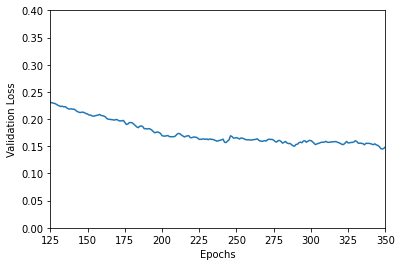

In [ ]:
# PLOT
plt.plot(range(1, len(avg_loss_hist) + 1), avg_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xlim([125, 350])
plt.ylim([0, .4])
plt.show()

In [ ]:
VALIDATION_ACCURACY

[0.8999999761581421, 1.0, 1.0, 0.9333333373069763]

In [ ]:
VALIDATION_LOSS

[0.41116318106651306,
 0.3003048300743103,
 0.09530989825725555,
 0.22158360481262207]

In [ ]:
np.mean(VALIDATION_ACCURACY)

0.9583333283662796

In [ ]:
np.mean(VALIDATION_LOSS)

0.25709037855267525

## Evaluate winning model

Once I finished tuning the parameters of my model, I trained the 'production' model on all of the traninng data and evaluated its performance on the test data.


In [ ]:
# Get a fresh compiled model & train it on the entirety of the dataset
model = build_model()

model.fit(x_train, y_train, epochs = 350,
                       batch_size = 8, callbacks = callbacks_list,
                       validation_data = (x_test, y_test), verbose = 0)

test_loss, test_acc = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.0521 - acc: 1.0000


In [ ]:
print('test_acc:', test_acc, 'test_loss:', test_loss, sep = '\n')

test_acc:
1.0
test_loss:
0.052141349762678146


## Conclusion

The final model had a test accuracy of 100% for three consecutive runs and 96.67% on the fourth run. The test loss ranged from 3.3 to 12.02%. Interestingly this is an improvement from the validation set accuracy and loss. The model is not overfit.


